# Food Vision Project

**Note :** For mixed precision training we need

*   List item
*   List item

to have a gpu with compute capability >7.0. Nvidia Geforce GTX 1650ti has a compute capability of 7.5

In [1]:
!nvidia-smi

Fri Aug  9 05:48:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-09 05:48:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-09 05:48:31 (93.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
import tensorflow as tf
# Get TensorFlow dataset
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print('food101' in datasets_list)

True


In [6]:
# Load the data
import tensorflow_datasets as tfds
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.CW6F3A_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.CW6F3A_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpkgfpu1rdtfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Looking at one dataset
train_one_sample = train_data.take(1)

In [11]:
len(train_one_sample)
# Samples are in format (image_tensor, label)

1

In [12]:
for image, label in train_one_sample:
  print(f'Image shape : {image.shape}') # Looking at the shape of our image tensor
  print(f'Label : {label}')
  print(f'Class name : {class_names[label]}')

Image shape : (512, 512, 3)
Label : 81
Class name : ramen


**The labels are not one-hot-encoded they are in numerical format**

In [13]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[242, 254, 252],
        [241, 253, 251],
        [240, 252, 250],
        ...,
        [241, 211, 101],
        [242, 212, 102],
        [245, 215, 105]],

       [[240, 252, 250],
        [240, 252, 250],
        [239, 251, 249],
        ...,
        [245, 215, 105],
        [242, 212, 102],
        [240, 210, 100]],

       [[238, 250, 248],
        [238, 250, 248],
        [238, 250, 248],
        ...,
        [250, 218, 107],
        [243, 211, 100],
        [238, 206,  95]],

       ...,

       [[ 82,  81,  77],
        [ 83,  82,  78],
        [ 82,  81,  77],
        ...,
        [126, 128, 127],
        [135, 137, 136],
        [139, 141, 140]],

       [[ 82,  79,  74],
        [ 82,  79,  74],
        [ 81,  78,  73],
        ...,
        [209, 209, 209],
        [217, 217, 217],
        [215, 215, 215]],

       [[ 78,  75,  70],
        [ 77,  74,  69],
        [ 76,  73,  68],
        ...,
        [187, 187, 18

In [14]:
# Getting the minimum and maximum value of the image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plotting one image from tensorflow dataset

(-0.5, 511.5, 511.5, -0.5)

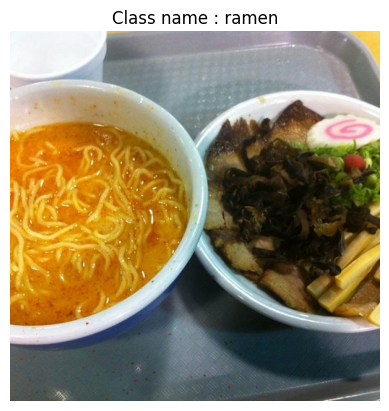

In [15]:
plt.imshow(image)
plt.title(f'Class name : {class_names[label.numpy()]}') # Adding title to verify the label is
# associated with the right image
plt.axis(False)

## Create preprocessing function for our data
Neural networks perform best when the data is in a certain way (batched , normalized etc)

so we often need to preprocess our data


Info about our data
* it is in `unit8` datatype
* Image tensors are of different size (different size images)
* Not Scaled

Data format that our model like:
* Data in `float32` dtype (or for mixed precision `float32`/`float16`)
* For batches, Tensorflow likes all the tensors within a batch should be of same size
* Scaled (values between 0 & 1)

EfficientNetBX don't need the tensors to be rescaled (rescaling is build in to it)

so our preprocessing function needs to be:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensor from `unit8` to `float32`.

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape the target image
  # image = image/255.
  return tf.cast(image, tf.float32), label # returns a tuple --> (float32_image, label)

In [17]:
# preprocessing a single image using the preprocessing function we created and check the outputs
preprocessed_img = preprocess_img(image, label)[0] # The 1st element of the tuplewhich the function returns
preprocessed_img.shape, preprocessed_img.dtype

(TensorShape([224, 224, 3]), tf.float32)

In [18]:
dataset = tf.data.Dataset.range(10)
x = dataset.take(3)
for i in dataset:
  print(i)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


## Batch and prepare data

In [19]:
# Map preprocessing function to train (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn into batchesand prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# Map the preprocessing function to test data (need ot to shuffle the test data)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating Callbacks for our model


In [21]:
import tensorflow as tf
from helper_functions import create_tensorboard_callback

# Creating ModelCheckpoint callback to save a model's progress during training
checkpoint_path = 'model_checkpoints/cp.weights.h5' # when the save _weigts_only is set to true then the file where the checkpoints to be stored should end with extention .weights.h
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=0
)


# Turn on mixed precision training


In [22]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [23]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential

In [25]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# NOTE: it is when we are using some other models but we ae using efficientnetB0 which already
#       has rescaling built-in
# x = tensorflow.keras.layers.Rescaling(1/255.)(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Checking the datatype of each layer in our model

In [27]:
for layer in model.layers:
  print(layer.name, layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [28]:
# Checking the dtype_policy attribute of the layers in the base model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable,layer.dtype,layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"


### Fiting the model

In [30]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                                                            experiment_name='efficientnetb0_101_classes_all_data_feature_extract'),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240809-061113
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 212s 88ms/step - accuracy: 0.6386 - loss: 1.4032 - val_accuracy: 0.6825 - val_loss: 1.1751
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6809 - val_loss: 1.1899
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 254s 89ms/step - accuracy: 0.6742 - loss: 1.2496 - val_accuracy: 0.6912 - val_loss: 1.1355


In [31]:
# Evaluate on whole test data
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.6916 - loss: 1.1479


[1.1421127319335938, 0.692435622215271]